#### XY - Rydberg interaction

In this tutorial, we show how the XY - Rydberg interaction can be used, and we compute some observables to verify the results. In general, we work with three-level systems where the basis states are the ground $|g\rangle$, the Rydberg state $|r\rangle$ for the Rydberg interaction, and an additional excited state $|r_1\rangle=|x\rangle$, which is used for the XY interaction and it is treated as a leakage state. In vector form, the basis states are:

$|g\rangle=\begin{bmatrix}1 \\ 0 \\ 0 \end{bmatrix}$, $|r\rangle=\begin{bmatrix}0 \\ 1 \\ 0 \end{bmatrix}$, $|r_1\rangle=\begin{bmatrix}0 \\ 0 \\ 1 \end{bmatrix}$.

With this setup, the leakage state allows us to combine both interactions using Lindblad operators.  However when the leake state $|x\rangle$ is measured, the corresponding output in the bitstrings is reported as 0.

We use a rydberg sequence with no driving ($\Omega=\delta=0$) and an initial state given by:

  $|rrr...r_1.....rrr\rangle $, where the state $|r_1\rangle$ is located in the middle of the chain. Since this is a Rydberg sequence without driving, we expect the XY interaction to transfer population to neighboring atoms.



In [1]:
import matplotlib.pyplot as plt
from emu_mps import (
    MPS,
    MPSConfig, 
    MPSBackend,
    BitStrings,
    Fidelity,
    Occupation
)

import pulser
from pulser.devices import MockDevice


import numpy as np
import torch

from pulser._hamiltonian_data import HamiltonianData # for getting the XY interaction matrix 

dtype = torch.complex128

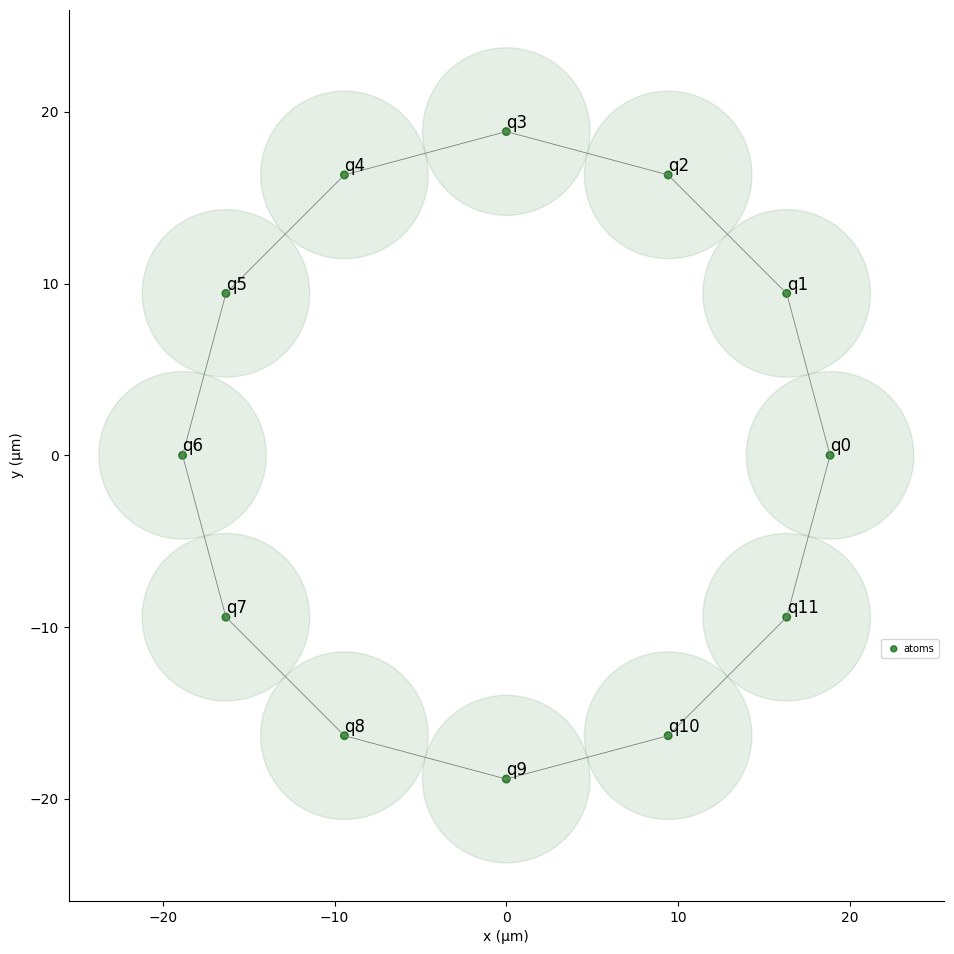

In [2]:
# creating the register
L = 12  # Number of atoms in the ring
Omega_max = 2 * np.pi
U = Omega_max 
# Define a ring of atoms distanced by the blockade radius distance:
R_interatomic = pulser.MockDevice.rydberg_blockade_radius(U)
coords = (
    R_interatomic
    / (2 * np.sin(np.pi / L))
    * np.array(
        [
            (np.cos(theta * 2 * np.pi / L), np.sin(theta * 2 * np.pi / L))
            for theta in range(L)
        ]
    )
)

# ring, periodic register
reg = pulser.Register.from_coordinates(coords, prefix="q")
# or try open boundaries
#reg = pulser.Register.rectangle(1,L,spacing=R_interatomic/1.2, prefix="q")

reg.draw(blockade_radius=R_interatomic, draw_half_radius=True, draw_graph=True)

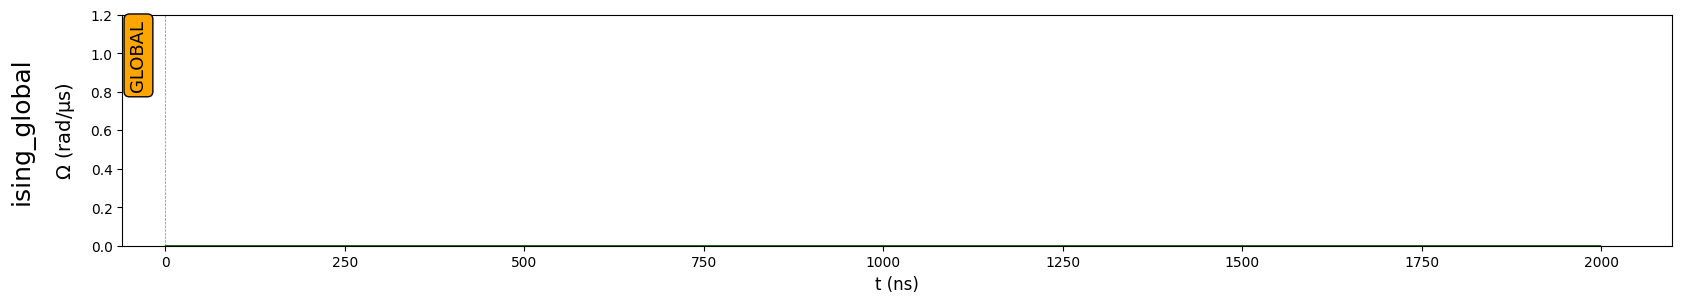

xy interaction matrix
 tensor([[0.0000, 3.9837, 0.5525, 0.1954, 0.1063, 0.0766, 0.0691, 0.0766, 0.1063,
         0.1954, 0.5525, 3.9837],
        [3.9837, 0.0000, 3.9837, 0.5525, 0.1954, 0.1063, 0.0766, 0.0691, 0.0766,
         0.1063, 0.1954, 0.5525],
        [0.5525, 3.9837, 0.0000, 3.9837, 0.5525, 0.1954, 0.1063, 0.0766, 0.0691,
         0.0766, 0.1063, 0.1954],
        [0.1954, 0.5525, 3.9837, 0.0000, 3.9837, 0.5525, 0.1954, 0.1063, 0.0766,
         0.0691, 0.0766, 0.1063],
        [0.1063, 0.1954, 0.5525, 3.9837, 0.0000, 3.9837, 0.5525, 0.1954, 0.1063,
         0.0766, 0.0691, 0.0766],
        [0.0766, 0.1063, 0.1954, 0.5525, 3.9837, 0.0000, 3.9837, 0.5525, 0.1954,
         0.1063, 0.0766, 0.0691],
        [0.0691, 0.0766, 0.1063, 0.1954, 0.5525, 3.9837, 0.0000, 3.9837, 0.5525,
         0.1954, 0.1063, 0.0766],
        [0.0766, 0.0691, 0.0766, 0.1063, 0.1954, 0.5525, 3.9837, 0.0000, 3.9837,
         0.5525, 0.1954, 0.1063],
        [0.1063, 0.0766, 0.0691, 0.0766, 0.1063, 0.1954, 

In [3]:
# create an example sequence with rydberg channel, no driving in the rydberg channel
cons_amplitud = pulser.Pulse.ConstantAmplitude(
    0.0, pulser.waveforms.RampWaveform(2000, 0.0, 0.0), 0.0
)
seq = pulser.Sequence(reg, MockDevice)
seq.declare_channel("ising_global", "rydberg_global")
seq.add(cons_amplitud, "ising_global")
seq.draw()

# specify the interaction matrix xy as torch tensor manually or using HamiltonianData from pulser
# sequence with xy model that uses the previous register in order to get the interaction xy matrix
const_pulse = pulser.Pulse.ConstantAmplitude(
    0.0, pulser.waveforms.RampWaveform(200, 0.0, np.pi), 0.0
)
seq_xy = pulser.Sequence(reg, MockDevice) # MockDevice has xy and ryderberg
seq_xy.declare_channel("mw_global", "mw_global")
seq_xy.add(const_pulse, "mw_global")

xy_ham_data = HamiltonianData.from_sequence(seq_xy)

interaction_matrix_xy = torch.tensor(xy_ham_data._interaction_matrix) # use torch tensor for interaction matrix xy
print("xy interaction matrix\n",interaction_matrix_xy)

In [ ]:
#initial state |rrr...r x rrr...r>
basis = ("g","r","x")  # basis using the leakage level for xy model
nqubits = len(seq.register.qubit_ids)
mid_num_qubits = nqubits // 2

#init_state = {"x"+"r"*(nqubits-1):1.0} # |> in ground-rydberg basis

init_state = {"r"*(mid_num_qubits) +"x"+"r"*(nqubits - mid_num_qubits-1):1.0} # |> in ground-rydberg basis

init_state_mps = MPS.from_state_amplitudes(
    eigenstates=basis, amplitudes=init_state
)

In [ ]:
dt = 10
eval_times = [1.0]
eval_times_list = [0.0,0.45,1.0]  #  time steps to measure the fidelity
sampling_times = 1000
bitstrings = BitStrings(evaluation_times=eval_times, num_shots=sampling_times)
nqubits = len(seq.register.qubit_ids)

state_for_test = {"x"+"r"*(nqubits-1): 1.0} # |xrrrr...> using the ground-rydberg basis

mps_for_test = MPS.from_state_amplitudes(
    eigenstates=basis, amplitudes=state_for_test
)
fidelity_mps_pure = Fidelity(evaluation_times=eval_times_list, state=mps_for_test)
density = Occupation(
    evaluation_times=[x/seq.get_duration() for x in range(0, seq.get_duration(), dt)]
)
#state = StateResult(evaluation_times=eval_times)

In [6]:
# lindbladians are using the leakage state |x> as |r1>.
# the basis will be |g>, |r>, |x>=|r1>
l1 = torch.zeros(3, 3, dtype=dtype)
l1[1, 2] = 1.0  # l1 = |r><x| = |r><r1| for xy model 
l2 = l1.mT  # l2 = |x><r|= |r1><r| for xy model
lindbladians = [l1, l2]

# in this case, no linblad operators (rates are 0.0) but we use with_leakeage = True 
noise_model = pulser.NoiseModel(
    eff_noise_opers=lindbladians,
    eff_noise_rates=(0.0, 0.0),  # decay from |r> to |r1> and from |r1> to |r>
    with_leakage=True,  # the leakage will be the |r1> for the xy model (|r> is |0>, |r1> is |1>)
)

In [7]:
# interaction = torch.rand(nqubits,nqubits)
# interaction = (interaction + interaction.mT)/2  # make it symmetric
# interaction.fill_diagonal_(0.0)  # zero diagonal
mpsconfig = MPSConfig(
    dt=dt,
    observables=[
        bitstrings,
        fidelity_mps_pure,
        density,
        #state
    ],
    interaction_matrix_xy= interaction_matrix_xy, # use the interaction matrix for xy model
    #interaction_matrix= interaction, # use the interaction matrix for rydberg model
    log_level=10,
    initial_state= init_state_mps,
    noise_model=noise_model
)

emu-mps allows only {'bitstrings', 'energy', 'energy_second_moment', 'statistics', 'energy_variance', 'correlation_matrix', 'occupation'} observables with `optimize_qubit_ordering = True`. you provided unsupported {'fidelity'} using `optimize_qubit_ordering = False` instead.


In [8]:
sim = MPSBackend(sequence=seq,config=mpsconfig)
results = sim.run()

emu-mps allows only {'bitstrings', 'energy', 'energy_second_moment', 'statistics', 'energy_variance', 'correlation_matrix', 'occupation'} observables with `optimize_qubit_ordering = True`. you provided unsupported {'fidelity'} using `optimize_qubit_ordering = False` instead.
Will save simulation state to file "emu_mps_save_5c9e0bec-f2b9-11f0-8e6d-37948995f8b2.dat"
            every inf seconds.
To resume: `MPSBackend().resume("/home/mauro/Documents/pasqal/code/emulators/docs/emu_mps/notebooks/emu_mps_save_5c9e0bec-f2b9-11f0-8e6d-37948995f8b2.dat")`
step = 1/200, χ = 2, |ψ| = 0.002 MB, RSS = 21.432 MB, Δt = 0.500 s
step = 2/200, χ = 2, |ψ| = 0.002 MB, RSS = 21.432 MB, Δt = 0.303 s
step = 3/200, χ = 2, |ψ| = 0.002 MB, RSS = 21.432 MB, Δt = 0.381 s
step = 4/200, χ = 2, |ψ| = 0.002 MB, RSS = 21.432 MB, Δt = 0.342 s
step = 5/200, χ = 2, |ψ| = 0.002 MB, RSS = 21.432 MB, Δt = 0.322 s
step = 6/200, χ = 2, |ψ| = 0.002 MB, RSS = 21.432 MB, Δt = 0.370 s
step = 7/200, χ = 2, |ψ| = 0.002 MB, RSS = 

The most frequent bitstring is ['111111101111'] which was sampled 137 times


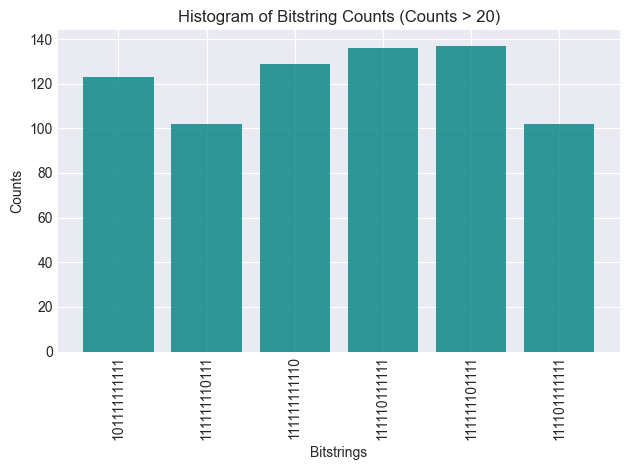

In [9]:
results.get_result_times(bitstrings)
bitstrings_final = results.get_result(bitstrings,1.0)
max_val = max(bitstrings_final.values())  # max number of counts in the bitstring
max_string = [key for key, value in bitstrings_final.items() if value == max_val]
print(
    "The most frequent bitstring is {} which was sampled {} times".format(
        max_string, max_val
    )
)

filtered_counts = [count for count in bitstrings_final.values() if count > 100]
filtered_bitstrings = [
    bitstring for bitstring, count in bitstrings_final.items() if count > 100
]
x_labels = range(len(filtered_bitstrings))
with plt.style.context("seaborn-v0_8-darkgrid"):
    fig, ax = plt.subplots()
    ax.bar(x_labels, filtered_counts, color="teal", alpha=0.8)
    ax.set_xlabel("Bitstrings")
    ax.set_ylabel("Counts")
    ax.set_title("Histogram of Bitstring Counts (Counts > 20)")
    ax.set_xticks(x_labels)
    ax.set_xticklabels(filtered_bitstrings, rotation="vertical")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()
    plt.show()

In [10]:
fidelity_pure = results.get_result(fidelity_mps_pure,1.0)

print(
    "The probability of the system being in the sate |x11111> is equal to {} ".format(
        fidelity_pure,
    )
)

for t in eval_times_list:
    print(results.get_result(fidelity_mps_pure, t))

The probability of the system being in the sate |x11111> is equal to 0.019913729338313 
tensor(0., dtype=torch.float64)
tensor(0.5229, dtype=torch.float64)
tensor(0.0199, dtype=torch.float64)


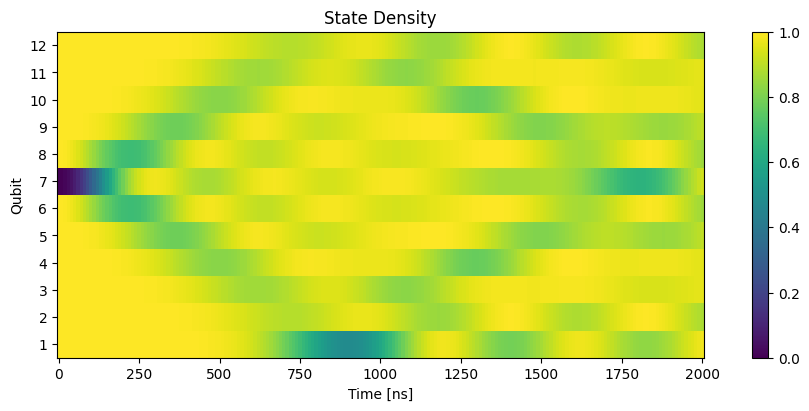

In [11]:
# population plot
magnetization_values = np.array(list(results.occupation))
magnetization_times = results.get_result_times(density)

# rescaling the time
real_times = []
for time in magnetization_times:
    real_times.append(time * seq.get_duration())
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")

num_time_points, positions = magnetization_values.shape
x, y = np.meshgrid(np.arange(num_time_points), np.arange(1, positions + 1))
im = plt.pcolormesh(real_times, y, magnetization_values.T, shading="auto")
ax.set_xlabel("Time [ns]")
ax.set_ylabel("Qubit")
ax.set_title("State Density")
ax.set_yticks(np.arange(1, positions + 1))
cb = fig.colorbar(im, ax=ax)